# Trashes Model Predict based on TACO Dataset and ImageAI lib

Let's create a model that perfom trashes detections and classifications in 28 classes considering the 1500 images provided by TACO Dataset

### Topics
1. **Exploratory Analysis** : Inspections on TACO dataset (Exploratory Analysis)

2. **Pre Processing**       :       Conversion beetwen COCO and VOC PASCAL formats

3. **Pre Processing**       :       Rescaling of TACO Dataset Images and Bounding Boxes parameters

4. **Training**             :       Training the model

5. **Evaluating**           :       Evaluating the model trained

6. **Final Considerations** :      Final considerations

### Requirements:
1. Image AI Lib Requirements: https://imageai.readthedocs.io/en/latest/#
2. Albumentations Lib Requirements: https://albumentations.ai/docs/getting_started/installation/
3. Open CV Libs
4. Taco Dataset: https://github.com/pedropro/TACO

### Instruction about the  TACO Dataset:
- See https://github.com/pedropro/TACO

#### Notebook Implemented by Tiago Sá
* Github: https://github.com/rTiagoS

In [1]:
# Libs

import json # To manipulate annotations json file
import xml.etree.ElementTree as ET # To generate the xml annotations


import numpy as np # To perform numeric operations on Digital Image Processing
import pandas as pd # To manipulate dataframes
import matplotlib.pyplot as plt # To visualize images
import seaborn as sns
import random # To visualize and image


import os # To manipulate the dataset input/output in differents formats
import pathlib # To get in on user folders and directories

import cv2 # Computacional Vision manipulations on Images from Taco Dataset
import albumentations as A # To pre processing images and also bounding boxes parameters


from imageai.Detection.Custom import DetectionModelTrainer # Create an instance to train
from imageai.Detection.Custom import CustomObjectDetection # Output the bouding boxes detected



%matplotlib inline

# Exploratory Analysis

In [6]:
# Bounding Boxes Colors
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White
dataset_format = 'coco'

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    
    if (dataset_format == 'coco'):
        x_min, y_min, w, h = bbox
        x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    elif (dataset_format =='pascal_voc'):
        x_min, y_min, x_max, y_max = bbox
    else:
        print('Invalid Format')

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [7]:
# Read annotations json file

dataset_path = '/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data'
anns_file_path = dataset_path + '/' + 'annotations.json'


with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())



In [15]:
def get_random_image(annotation_json_file):
    
    categories  = annotation_json_file['categories']
    annotations = annotation_json_file['annotations']
    images      = annotation_json_file['images']

    rand_number = random.randrange(0, len(images))
    
    image_path = images[rand_number]['file_name']
    image_path = dataset_path + '/' + image_path # Just an image path
    
    image = cv2.imread(image_path) # Read an image to show an example

    bboxes = []
    category_ids = []
    category_id_to_name = {}
    height = images[rand_number]['height']
    width = images[rand_number]['width']
    
    for i in range(0, len(annotations)):
        if (annotations[i]['image_id'] == rand_number):
            bboxes.append(
                [np.abs(annotations[i]['bbox'][0]),
                 np.abs(annotations[i]['bbox'][1]),
                 np.abs(annotations[i]['bbox'][2]),
                 np.abs(annotations[i]['bbox'][3])])

            category_ids.append(annotations[i]['category_id'])
    for key in category_ids:
        category_id_to_name[key] = '{}'.format(categories[key]['name'])
    
    return [image,
            bboxes,
            category_ids,
            category_id_to_name,
            height,
            width,
            image_path,
            rand_number]


# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [9]:
img_obj = get_random_image(dataset)
image               = img_obj[0]
bboxes              = img_obj[1]
category_ids        = img_obj[2]
category_id_to_name = img_obj[3]
height              = img_obj[4]
width               = img_obj[5]

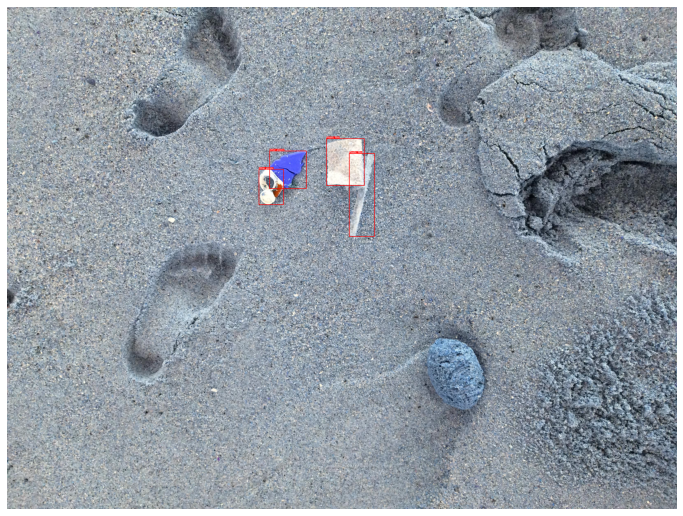

In [10]:
# Visualize the random image with associated bounding boxes
visualize(image, bboxes, category_ids, category_id_to_name)

In [11]:
# Creating the pipeline to apply a transformation to reduce the dimensionality of the
# original images. Resize from 100% to 20% (0.2 factor) 

transform = A.Compose([
    A.Resize(height = int(height*0.2), width = int(width*0.2), interpolation=1, always_apply=False, p=1)
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids'] ))

In [12]:
# Applying resizing (scalation) both on Images and Bounding Boxes

transformed = transform(image=image, bboxes=bboxes, category_ids = category_ids)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_labels = transformed['category_ids']

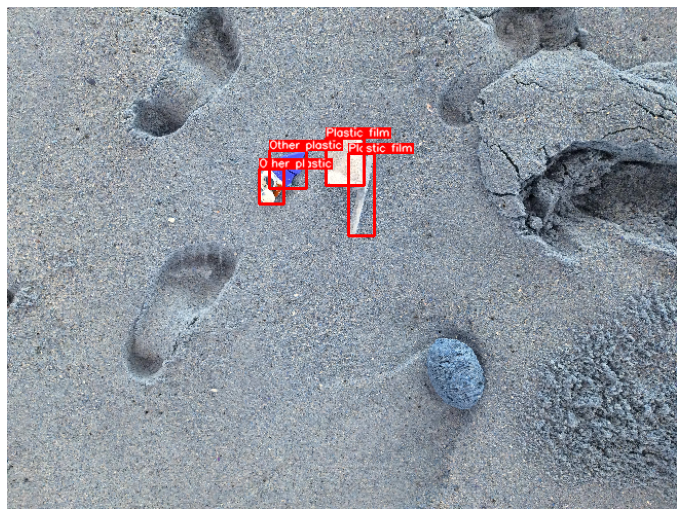

In [13]:
visualize(transformed_image, transformed_bboxes, transformed_labels, category_id_to_name )

In [14]:
# Now let's check the classes distribution between the 1500 images

dataset_path = '/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data'
anns_file_path = dataset_path + '/' + 'annotations.json'

categories  = dataset['categories']
annotations = dataset['annotations']
images      = dataset['images']


# From here we can realize that there are 60 subclasses
sub_categories = []
super_categories = []
for i in range(0, len(categories)):
    sub_categories.append(categories[i]['name'])
    super_categories.append(categories[i]['supercategory'])

nr_cats = len(sub_categories)

print(" Number of sub categories: {} ".format(nr_cats))
print("\n Number of super categories: {} ".format(len(np.unique(super_categories))))
print("\n Number of images: {}".format(len(images)))
print("\n Number of annotations: {}".format(len(annotations)))

# From here we can realize that there are so many classes and subclasses. 


 Number of sub categories: 60 

 Number of super categories: 28 

 Number of images: 1500

 Number of annotations: 4784


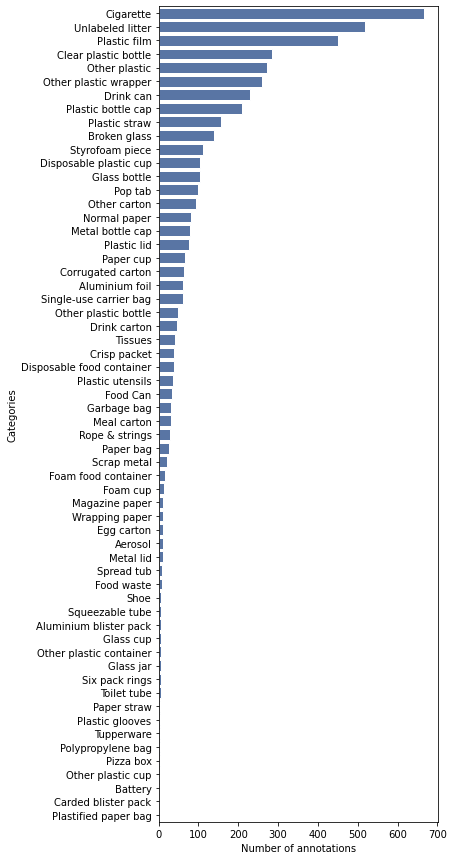

In [15]:
# Before make some considerations about the relation between the number of classes and the
# images instances, let's inspection how the classes are distributed between the images

# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in annotations:
    cat_histogram[ann['category_id']] += 1
    
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,15))

# Convert to DataFrame
df = pd.DataFrame({'Categories': sub_categories, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

#Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")
# The bar plot below shows us that the sub classes are not evenly distributed between
# the annotations.

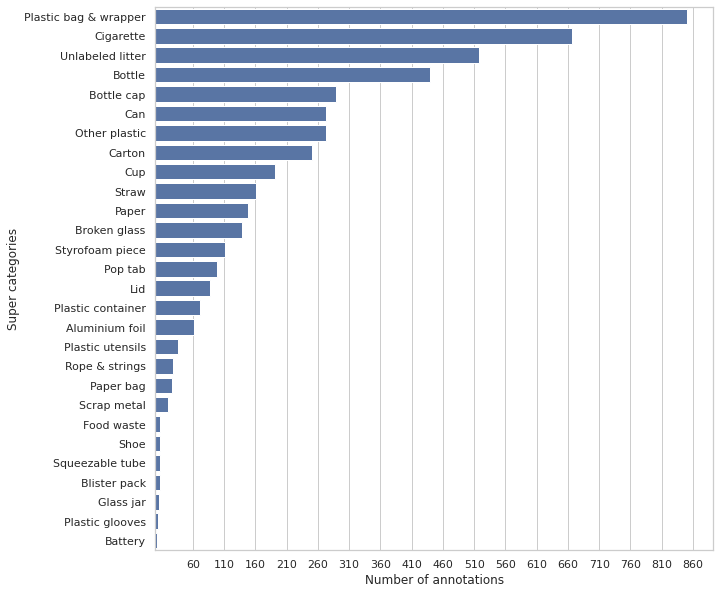

In [16]:
categories = dataset['categories']
annotations = dataset['annotations']
images = dataset['images']
nr_cats = len(categories)
nr_annotations = len(annotations)
nr_images = len(images)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

cat_ids_2_supercat_ids = {}
for cat in categories:
    cat_ids_2_supercat_ids[cat['id']] = super_cat_ids[cat['supercategory']]

# Count annotations
super_cat_histogram = np.zeros(nr_super_cats,dtype=int)
for ann in annotations:
    cat_id = ann['category_id']
    super_cat_histogram[cat_ids_2_supercat_ids[cat_id]] +=1
    
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

plt.xticks(np.arange(60, 900, 50))

# Convert to DataFrame
d ={'Super categories': super_cat_names, 'Number of annotations': super_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

# sns.set_color_codes("pastel")
# sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total", color="b")
#plot_1.set_title('Annotations per super category',fontsize=20)  

# Pre Processing 

In [17]:
# Lets reduce the 60 categories into 28 (optional)
# PATCHED
def transform_supercategories(annotation_json_file):
    """ Transform the 28 supercategories into just 6 supercategories"""
    
    annotations = annotation_json_file['annotations']
    categories = annotation_json_file['categories']

    Blue = ['Paper', 'Paper bag', 'Carton', 'Cigarette']    
    Green = ['Broken glass','Glass jar']
    Red = ['Other plastic', 'Plastic bag & wrapper', 
           'Plastic container','Plastic utensils', 'Straw', 'Squeezable tube',
           'Plastico glooves']
    Yellow = ['Scrap metal', 'Battery', 'Aluminium foil']
    Brown = ['Food waste']
    Other = ['Blister pack', 'Bottle', 'Bottle cap', 'Can','Cup', 'Lid', 'Pop tab',
             'Rope & strings',  'Shoe', 'Styrofoam piece', 'Unlabeled litter']

    for annotation in annotations:
        if (categories[annotation['category_id']]['supercategory'] in Blue):
            categories[annotation['category_id']]['supercategory'] = 'Blue'

        elif (categories[annotation['category_id']]['supercategory'] in Green):
            categories[annotation['category_id']]['supercategory'] = 'Green'

        elif (categories[annotation['category_id']]['supercategory'] in Red):
            categories[annotation['category_id']]['supercategory'] = 'Red'

        elif (categories[annotation['category_id']]['supercategory'] in Yellow):
            categories[annotation['category_id']]['supercategory'] = 'Yellow'

        elif (categories[annotation['category_id']]['supercategory'] in Brown):
            categories[annotation['category_id']]['supercategory'] = 'Brown'

        elif (categories[annotation['category_id']]['supercategory'] in Other):
            categories[annotation['category_id']]['supercategory'] = 'Others'
            
#         else:
#             print(" Failed! category not found. ")
    return annotation_json_file



In [332]:
# with open(anns_file_path, 'r') as f:
#     dataset = json.loads(f.read())
# dataset = transform_supercategories(dataset)

In [18]:
# Let's resize all the the images from TACO Dataset and update the Bounding Boxes in the 
# annotatations json file as well

def resize_and_update(anns_file_path):
    """Update the following parameters with the new scale: 
    1. Image Widht and Height;
    2. Bounding Boxes Parameters
    3. And also generate the images resized"""
    
    output_dir = dataset_path + '/resized_images'

    with open(anns_file_path, 'r') as f:
         annotation_json_file = json.loads(f.read())
    
    # Root directory of the dataset
    os.chdir(dataset_path)
    
    # Create the output_dir
    os.mkdir(output_dir)
    
    images      = annotation_json_file['images']
    annotations = annotation_json_file['annotations']
    categories  = annotation_json_file['categories']
    
    for k in range(0, len(images)): # Go through all the images
        
        # Update the height and width with the appropriate rescale factor.
        images[k]['width'] = int(images[k]['width']*0.10) 
        images[k]['height'] = int(images[k]['height']*0.10)
        
        # Read the image through the iterations
        image = cv2.imread('{}'.format(images[k]['file_name']))
        
        # Declaring arrays and dic to update postwards
        bboxes = []
        category_ids = []
        category_id_to_name ={}

        # Go through all the annotations
        for j in range(0, len(annotations)):
            if (annotations[j]['image_id'] == k): # When finding the correct iteration
                # Get the bounding boxes
                bboxes.append(
                    [np.abs(annotations[j]['bbox'][0]),
                    np.abs(annotations[j]['bbox'][1]),
                    np.abs(annotations[j]['bbox'][2]),
                    np.abs(annotations[j]['bbox'][3])])
                
                # Get the corresponding category id
                category_ids.append(annotations[j]['category_id'])
                
        for key in category_ids:
            # Get the corresponding label associated to the category id
            category_id_to_name[key] = '{}'.format(categories[key]['supercategory'])
            
        # Apply the rescale transformation on the image and bounding boxes    
        transform = A.Compose([
            A.Resize(height = images[k]['height'], width = images[k]['width'],
                     interpolation=1, always_apply=False, p=1)
        ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))
        
        # Get the objects after the transformation is applied
        transformed = transform(image = image, bboxes = bboxes, category_ids = category_ids)
        transformed_image  = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_labels = transformed['category_ids']
        
        ## SECTION TO UPDATE THE BOUNDING BOXES ANNOTATIONS ## 
        i = 0
        for j in range(0, len(annotations)):
            if (annotations[j]['image_id'] == k):
                if (i < len(transformed_bboxes)):
                    annotations[j]['bbox'][0] = int(transformed_bboxes[i][0])
                    annotations[j]['bbox'][1] = int(transformed_bboxes[i][1])
                    annotations[j]['bbox'][2] = int(transformed_bboxes[i][2])
                    annotations[j]['bbox'][3] = int(transformed_bboxes[i][3])
                    i+=1
        
        # Save the images after the resize
        cv2.imwrite('{}/resized_images/{}'.format(dataset_path,'{:0>6}.jpg'.format(k)),
                    transformed_image)
        print('Image{} rescaled!'.format(k))
    
    print("Images rescaled successfully!\nAnnotation Json File updated succesfully!")
    return annotation_json_file

In [386]:
dataset = resize_and_update(anns_file_path)


Image0 rescaled!
Image1 rescaled!
Image2 rescaled!
Image3 rescaled!
Image4 rescaled!
Image5 rescaled!
Image6 rescaled!
Image7 rescaled!
Image8 rescaled!
Image9 rescaled!
Image10 rescaled!
Image11 rescaled!
Image12 rescaled!
Image13 rescaled!
Image14 rescaled!
Image15 rescaled!
Image16 rescaled!
Image17 rescaled!
Image18 rescaled!
Image19 rescaled!
Image20 rescaled!
Image21 rescaled!
Image22 rescaled!
Image23 rescaled!
Image24 rescaled!
Image25 rescaled!
Image26 rescaled!
Image27 rescaled!
Image28 rescaled!
Image29 rescaled!
Image30 rescaled!
Image31 rescaled!
Image32 rescaled!
Image33 rescaled!
Image34 rescaled!
Image35 rescaled!
Image36 rescaled!
Image37 rescaled!
Image38 rescaled!
Image39 rescaled!
Image40 rescaled!
Image41 rescaled!
Image42 rescaled!
Image43 rescaled!
Image44 rescaled!
Image45 rescaled!
Image46 rescaled!
Image47 rescaled!
Image48 rescaled!
Image49 rescaled!
Image50 rescaled!
Image51 rescaled!
Image52 rescaled!
Image53 rescaled!
Image54 rescaled!
Image55 rescaled!
Im

Image437 rescaled!
Image438 rescaled!
Image439 rescaled!
Image440 rescaled!
Image441 rescaled!
Image442 rescaled!
Image443 rescaled!
Image444 rescaled!
Image445 rescaled!
Image446 rescaled!
Image447 rescaled!
Image448 rescaled!
Image449 rescaled!
Image450 rescaled!
Image451 rescaled!
Image452 rescaled!
Image453 rescaled!
Image454 rescaled!
Image455 rescaled!
Image456 rescaled!
Image457 rescaled!
Image458 rescaled!
Image459 rescaled!
Image460 rescaled!
Image461 rescaled!
Image462 rescaled!
Image463 rescaled!
Image464 rescaled!
Image465 rescaled!
Image466 rescaled!
Image467 rescaled!
Image468 rescaled!
Image469 rescaled!
Image470 rescaled!
Image471 rescaled!
Image472 rescaled!
Image473 rescaled!
Image474 rescaled!
Image475 rescaled!
Image476 rescaled!
Image477 rescaled!
Image478 rescaled!
Image479 rescaled!
Image480 rescaled!
Image481 rescaled!
Image482 rescaled!
Image483 rescaled!
Image484 rescaled!
Image485 rescaled!
Image486 rescaled!
Image487 rescaled!
Image488 rescaled!
Image489 res

Image871 rescaled!
Image872 rescaled!
Image873 rescaled!
Image874 rescaled!
Image875 rescaled!
Image876 rescaled!
Image877 rescaled!
Image878 rescaled!
Image879 rescaled!
Image880 rescaled!
Image881 rescaled!
Image882 rescaled!
Image883 rescaled!
Image884 rescaled!
Image885 rescaled!
Image886 rescaled!
Image887 rescaled!
Image888 rescaled!
Image889 rescaled!
Image890 rescaled!
Image891 rescaled!
Image892 rescaled!
Image893 rescaled!
Image894 rescaled!
Image895 rescaled!
Image896 rescaled!
Image897 rescaled!
Image898 rescaled!
Image899 rescaled!
Image900 rescaled!
Image901 rescaled!
Image902 rescaled!
Image903 rescaled!
Image904 rescaled!
Image905 rescaled!
Image906 rescaled!
Image907 rescaled!
Image908 rescaled!
Image909 rescaled!
Image910 rescaled!
Image911 rescaled!
Image912 rescaled!
Image913 rescaled!
Image914 rescaled!
Image915 rescaled!
Image916 rescaled!
Image917 rescaled!
Image918 rescaled!
Image919 rescaled!
Image920 rescaled!
Image921 rescaled!
Image922 rescaled!
Image923 res

Image1288 rescaled!
Image1289 rescaled!
Image1290 rescaled!
Image1291 rescaled!
Image1292 rescaled!
Image1293 rescaled!
Image1294 rescaled!
Image1295 rescaled!
Image1296 rescaled!
Image1297 rescaled!
Image1298 rescaled!
Image1299 rescaled!
Image1300 rescaled!
Image1301 rescaled!
Image1302 rescaled!
Image1303 rescaled!
Image1304 rescaled!
Image1305 rescaled!
Image1306 rescaled!
Image1307 rescaled!
Image1308 rescaled!
Image1309 rescaled!
Image1310 rescaled!
Image1311 rescaled!
Image1312 rescaled!
Image1313 rescaled!
Image1314 rescaled!
Image1315 rescaled!
Image1316 rescaled!
Image1317 rescaled!
Image1318 rescaled!
Image1319 rescaled!
Image1320 rescaled!
Image1321 rescaled!
Image1322 rescaled!
Image1323 rescaled!
Image1324 rescaled!
Image1325 rescaled!
Image1326 rescaled!
Image1327 rescaled!
Image1328 rescaled!
Image1329 rescaled!
Image1330 rescaled!
Image1331 rescaled!
Image1332 rescaled!
Image1333 rescaled!
Image1334 rescaled!
Image1335 rescaled!
Image1336 rescaled!
Image1337 rescaled!


In [19]:
def gen_dataframe_filenames(annotation_json_file):
    """Generate a dataframe containing the original image filename and its associated 
    generated filename"""

    images = annotation_json_file['images']

    # Root directory of the dataset
    os.chdir(dataset_path)

    df_filenames = pd.DataFrame(columns = ['original_filename', 'corresponding_filename'])
    
    for i in range(0, len(images)):
    
        images_filename = images[i]['file_name'].split('/')[1]
        images_path = images[i]['file_name']
    
        df_buffer = pd.DataFrame([['{}'.format(images_filename),
                                   '{:0>6}.jpg'.format(i)]],
                                 columns = ['original_filename', 'corresponding_filename'])
    
        df_filenames = pd.concat([df_filenames, df_buffer]).reset_index(drop=True)
    return df_filenames

In [20]:
df_filenames = gen_dataframe_filenames(dataset)
df_filenames.head()

original_filename corresponding_filename
0        000006.jpg             000000.jpg
1        000008.jpg             000001.jpg
2        000010.jpg             000002.jpg
3        000019.jpg             000003.jpg
4        000026.jpg             000004.jpg

In [389]:
def coco_to_pascal(annotation_json_file, df_filenames):

    images_path = '/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/images'
    output_dir = dataset_path + '/xml_annotations'

    # Root directory of the dataset
    os.chdir(dataset_path)
    
    # Create the output_dir
    os.mkdir(output_dir)

    # Root directory of the dataset
    os.chdir(output_dir)

    images = annotation_json_file['images']
    annotations = annotation_json_file['annotations']
    categories = annotation_json_file['categories']
 
    for i in range(0, len(images)):

        xml_annotation = ET.Element('annotation') 

        xml_folder = ET.SubElement(xml_annotation, 'folder')

        xml_filename = ET.SubElement(xml_annotation, 'filename')
        xml_filename.text = df_filenames['corresponding_filename'][i]

        xml_path = ET.SubElement(xml_annotation, 'path')
        xml_path.text = df_filenames['corresponding_filename'][i]
    
        xml_source = ET.SubElement(xml_annotation, 'source')
        xml_database = ET.SubElement(xml_source, 'database')
        xml_database.text = 'TACO Dataset'
    
        xml_size = ET.SubElement(xml_annotation, 'size')
        xml_width = ET.SubElement(xml_size, 'width')
        xml_height = ET.SubElement(xml_size, 'height')
        xml_depth = ET.SubElement(xml_size, 'depth')
        xml_width.text = '{}'.format(images[i]['width'])
        xml_height.text = '{}'.format(images[i]['height'])
        xml_depth.text = '3'
    
        xml_segmented = ET.SubElement(xml_annotation, 'segmented')
        xml_segmented.text = '0'
    
        ####### OBJECT PART #######
    
        for j in range(0, len(annotations)):
            if (annotations[j]['image_id'] == i):
                xml_object = ET.SubElement(xml_annotation, 'object')
                xml_name = ET.SubElement(xml_object, 'name')
                xml_pose = ET.SubElement(xml_object, 'pose')
                xml_truncated = ET.SubElement(xml_object, 'truncated')
                xml_difficult = ET.SubElement(xml_object, 'difficult')
                xml_occluded = ET.SubElement(xml_object, 'occluded')

                xml_bndbox  = ET.SubElement(xml_object, 'bndbox')       
                xml_xmin = ET.SubElement(xml_bndbox, 'xmin')
                xml_ymin = ET.SubElement(xml_bndbox, 'ymin')
                xml_xmax = ET.SubElement(xml_bndbox, 'xmax')
                xml_ymax = ET.SubElement(xml_bndbox, 'ymax')

            

                category_id = annotations[j]['category_id']

                xml_name.text = categories[category_id]['supercategory']
                xml_pose.text = 'Unspecified'
                xml_truncated.text = '0'
                xml_difficult.text = '0'
                xml_occluded.text = '0'
                
                # Conversion between COCO and PASCAL VOC formats
                xml_xmin.text = '{}'.format(int(annotations[j]['bbox'][0]))
                xml_ymin.text = '{}'.format(int(annotations[j]['bbox'][1]))
                xml_xmax.text = '{}'.format(int(annotations[j]['bbox'][2] +
                                                annotations[j]['bbox'][0]))
                xml_ymax.text = '{}'.format(int(annotations[j]['bbox'][3] +
                                                annotations[j]['bbox'][1]))

        
        b_xml = ET.tostring(xml_annotation) 

        # Save the xml pascal voc format file
        with open("{}.xml".format(df_filenames['corresponding_filename'][i].split('.')[0]), "wb") as f: 
            f.write(b_xml)
        
        print('Pascal Voc {} generated!'.format(i))
    
    print("xml files generated succesfully")

In [390]:
coco_to_pascal(dataset, df_filenames)

Pascal Voc 0 generated!
Pascal Voc 1 generated!
Pascal Voc 2 generated!
Pascal Voc 3 generated!
Pascal Voc 4 generated!
Pascal Voc 5 generated!
Pascal Voc 6 generated!
Pascal Voc 7 generated!
Pascal Voc 8 generated!
Pascal Voc 9 generated!
Pascal Voc 10 generated!
Pascal Voc 11 generated!
Pascal Voc 12 generated!
Pascal Voc 13 generated!
Pascal Voc 14 generated!
Pascal Voc 15 generated!
Pascal Voc 16 generated!
Pascal Voc 17 generated!
Pascal Voc 18 generated!
Pascal Voc 19 generated!
Pascal Voc 20 generated!
Pascal Voc 21 generated!
Pascal Voc 22 generated!
Pascal Voc 23 generated!
Pascal Voc 24 generated!
Pascal Voc 25 generated!
Pascal Voc 26 generated!
Pascal Voc 27 generated!
Pascal Voc 28 generated!
Pascal Voc 29 generated!
Pascal Voc 30 generated!
Pascal Voc 31 generated!
Pascal Voc 32 generated!
Pascal Voc 33 generated!
Pascal Voc 34 generated!
Pascal Voc 35 generated!
Pascal Voc 36 generated!
Pascal Voc 37 generated!
Pascal Voc 38 generated!
Pascal Voc 39 generated!
Pascal Voc

Pascal Voc 487 generated!
Pascal Voc 488 generated!
Pascal Voc 489 generated!
Pascal Voc 490 generated!
Pascal Voc 491 generated!
Pascal Voc 492 generated!
Pascal Voc 493 generated!
Pascal Voc 494 generated!
Pascal Voc 495 generated!
Pascal Voc 496 generated!
Pascal Voc 497 generated!
Pascal Voc 498 generated!
Pascal Voc 499 generated!
Pascal Voc 500 generated!
Pascal Voc 501 generated!
Pascal Voc 502 generated!
Pascal Voc 503 generated!
Pascal Voc 504 generated!
Pascal Voc 505 generated!
Pascal Voc 506 generated!
Pascal Voc 507 generated!
Pascal Voc 508 generated!
Pascal Voc 509 generated!
Pascal Voc 510 generated!
Pascal Voc 511 generated!
Pascal Voc 512 generated!
Pascal Voc 513 generated!
Pascal Voc 514 generated!
Pascal Voc 515 generated!
Pascal Voc 516 generated!
Pascal Voc 517 generated!
Pascal Voc 518 generated!
Pascal Voc 519 generated!
Pascal Voc 520 generated!
Pascal Voc 521 generated!
Pascal Voc 522 generated!
Pascal Voc 523 generated!
Pascal Voc 524 generated!
Pascal Voc 5

Pascal Voc 887 generated!
Pascal Voc 888 generated!
Pascal Voc 889 generated!
Pascal Voc 890 generated!
Pascal Voc 891 generated!
Pascal Voc 892 generated!
Pascal Voc 893 generated!
Pascal Voc 894 generated!
Pascal Voc 895 generated!
Pascal Voc 896 generated!
Pascal Voc 897 generated!
Pascal Voc 898 generated!
Pascal Voc 899 generated!
Pascal Voc 900 generated!
Pascal Voc 901 generated!
Pascal Voc 902 generated!
Pascal Voc 903 generated!
Pascal Voc 904 generated!
Pascal Voc 905 generated!
Pascal Voc 906 generated!
Pascal Voc 907 generated!
Pascal Voc 908 generated!
Pascal Voc 909 generated!
Pascal Voc 910 generated!
Pascal Voc 911 generated!
Pascal Voc 912 generated!
Pascal Voc 913 generated!
Pascal Voc 914 generated!
Pascal Voc 915 generated!
Pascal Voc 916 generated!
Pascal Voc 917 generated!
Pascal Voc 918 generated!
Pascal Voc 919 generated!
Pascal Voc 920 generated!
Pascal Voc 921 generated!
Pascal Voc 922 generated!
Pascal Voc 923 generated!
Pascal Voc 924 generated!
Pascal Voc 9

Pascal Voc 1372 generated!
Pascal Voc 1373 generated!
Pascal Voc 1374 generated!
Pascal Voc 1375 generated!
Pascal Voc 1376 generated!
Pascal Voc 1377 generated!
Pascal Voc 1378 generated!
Pascal Voc 1379 generated!
Pascal Voc 1380 generated!
Pascal Voc 1381 generated!
Pascal Voc 1382 generated!
Pascal Voc 1383 generated!
Pascal Voc 1384 generated!
Pascal Voc 1385 generated!
Pascal Voc 1386 generated!
Pascal Voc 1387 generated!
Pascal Voc 1388 generated!
Pascal Voc 1389 generated!
Pascal Voc 1390 generated!
Pascal Voc 1391 generated!
Pascal Voc 1392 generated!
Pascal Voc 1393 generated!
Pascal Voc 1394 generated!
Pascal Voc 1395 generated!
Pascal Voc 1396 generated!
Pascal Voc 1397 generated!
Pascal Voc 1398 generated!
Pascal Voc 1399 generated!
Pascal Voc 1400 generated!
Pascal Voc 1401 generated!
Pascal Voc 1402 generated!
Pascal Voc 1403 generated!
Pascal Voc 1404 generated!
Pascal Voc 1405 generated!
Pascal Voc 1406 generated!
Pascal Voc 1407 generated!
Pascal Voc 1408 generated!
P

In [393]:
dataset['annotations'][0]['bbox']

[51, 12, 44, 131]

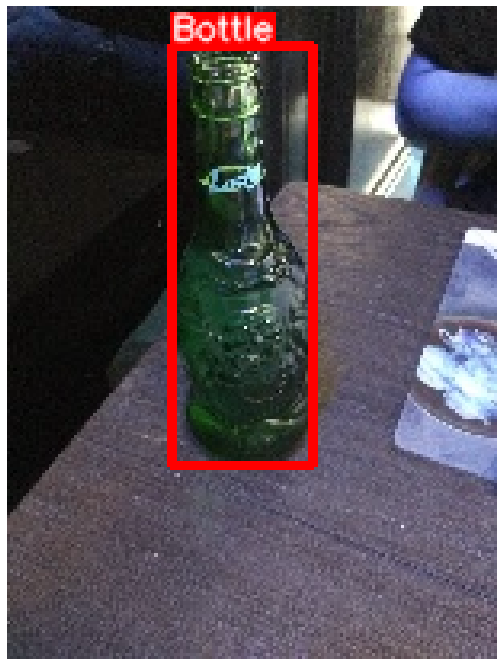

In [394]:
# Let's check if the xml files were correctly generated through a visualization

#Choosing an arbitrary image
image_filename = '000000.jpg'
image_path = dataset_path + '/resized_images/' + image_filename
image = cv2.imread(image_path)

# Change the dataset_format visualization
dataset_format = 'pascal_voc' 

# I manually got the bounding box at the xml folder
bboxes = [[51, 12, 95, 143]]
category_ids = [6]
category_id_to_name = {6: 'Bottle'}

visualize(image, bboxes, category_ids, category_id_to_name)

In [21]:
# Checking if there are some categories label that are not used:

categories_labels = []
for i in range(0, len(annotations)):
    categories_labels.append(annotations[i]['category_id'])

# Realize that 35 it's present
np.unique(categories_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59])

In [22]:
categories_labels = []
for i in range(0, len(categories)):
    categories_labels.append(categories[i]['supercategory'])
# categories[35]['supercategory']
categories_labels = list(np.unique(categories_labels))

# Training a model

In [24]:
import tensorflow as tf
# Checar disponibilidade de GPUS:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1

Num GPUs Available:  1


In [ ]:
# The code below follows according to the Image AI Custom Detection Model Documentation
# more info: 
# https://github.com/OlafenwaMoses/ImageAI/blob/master/imageai/Detection/Custom/CUSTOMDETECTIONTRAINING.md

# Using transfer learning (recommended for better accuracy) from a pre-trained YOLOv3 model
# to train a new model


PRETRAINED_MODEL_DIR = '/home/trs/ML_Projects/Huawei_Curupira/Notebooks/pretrained-yolov3.h5'
BATCH_SIZE = 4
DATASET_DIR = '/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/'

trainer = DetectionModelTrainer() 
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory =DATASET_DIR)
trainer.setTrainConfig(object_names_array=categories_labels, batch_size=BATCH_SIZE,train_from_pretrained_model=PRETRAINED_MODEL_DIR, num_experiments = 75)
trainer.trainModel()

Generating anchor boxes for training images and annotation...
Average IOU for 9 anchors: 0.57
Anchor Boxes generated.
Detection configuration saved in  /home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/json/detection_config.json
Evaluating over 300 samples taken from /home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/validation
Training over 1200 samples  given at /home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/train
Training on: 	['Aluminium foil', 'Battery', 'Blister pack', 'Bottle', 'Bottle cap', 'Broken glass', 'Can', 'Carton', 'Cigarette', 'Cup', 'Food waste', 'Glass jar', 'Lid', 'Other plastic', 'Paper', 'Paper bag', 'Plastic bag & wrapper', 'Plastic container', 'Plastic glooves', 'Plastic utensils', 'Pop tab', 'Rope & strings', 'Scrap metal', 'Shoe', 'Squeezable tube', 'Straw', 'Styrofoam piece', 'Unlabeled litter']
Training with Batch Size:  4
Number of Training Samples:  1200
Number of Validation Sa

/home/trs/ML_Projects/Huawei_Curupira/curupira_env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/trs/ML_Projects/Huawei_Curupira/curupira_env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/75
2400/2400 [==============================] - 1511s 622ms/step - loss: 43.2943 - yolo_layer_loss: 4.2081 - yolo_layer_1_loss: 10.6542 - yolo_layer_2_loss: 19.8274 - val_loss: 26.1873 - val_yolo_layer_loss: 0.3603 - val_yolo_layer_1_loss: 4.9371 - val_yolo_layer_2_loss: 16.5928
Epoch 2/75
2400/2400 [==============================] - 1518s 632ms/step - loss: 27.4267 - yolo_layer_loss: 3.3241 - yolo_layer_1_loss: 7.2031 - yolo_layer_2_loss: 12.8875 - val_loss: 24.5287 - val_yolo_layer_loss: 0.4416 - val_yolo_layer_1_loss: 5.1838 - val_yolo_layer_2_loss: 15.5861
Epoch 3/75
2400/2400 [==============================] - 1488s 620ms/step - loss: 25.6599 - yolo_layer_loss: 3.3065 - yolo_layer_1_loss: 6.7365 - yolo_layer_2_loss: 12.4507 - val_loss: 23.5310 - val_yolo_layer_loss: 0.5124 - val_yolo_layer_1_loss: 4.9598 - val_yolo_layer_2_loss: 15.2635
Epoch 4/75
2400/2400 [==============================] - 1473s 613ms/step - loss: 24.3251 - yolo_layer_loss: 2.8496 - yolo_layer_1_loss: 6.

2400/2400 [==============================] - 1526s 636ms/step - loss: 18.1380 - yolo_layer_loss: 2.6129 - yolo_layer_1_loss: 4.3714 - yolo_layer_2_loss: 9.7578 - val_loss: 19.4157 - val_yolo_layer_loss: 0.4518 - val_yolo_layer_1_loss: 3.5504 - val_yolo_layer_2_loss: 14.0177
Epoch 58/75
2400/2400 [==============================] - 1535s 640ms/step - loss: 18.1343 - yolo_layer_loss: 2.5845 - yolo_layer_1_loss: 4.2900 - yolo_layer_2_loss: 9.8640 - val_loss: 19.4252 - val_yolo_layer_loss: 0.4884 - val_yolo_layer_1_loss: 3.6263 - val_yolo_layer_2_loss: 13.9146
Epoch 59/75
1750/2400 [====================>.........] - ETA: 6:28 - loss: 17.9282 - yolo_layer_loss: 2.5413 - yolo_layer_1_loss: 4.1191 - yolo_layer_2_loss: 9.8719

# Evaluating the Model Trained

In [4]:


os.chdir('/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format')
TRAINED_MODEL_DIR = '/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/models/detection_model-ex-053--loss-0018.087.h5'
DATASET_DIR = '/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/'

trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory=DATASET_DIR)
metrics = trainer.evaluateModel(model_path=TRAINED_MODEL_DIR, json_path="json/detection_config.json")
print(metrics)

Starting Model evaluation....
Evaluating over 300 samples taken from /home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/validation
Training over 1200 samples  given at /home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/train
Model File:  /home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/models/detection_model-ex-053--loss-0018.087.h5 

Evaluation samples:  300
Using IoU:  0.5
Using Object Threshold:  0.2
Using Non-Maximum Suppression:  0.45
Aluminium foil: 0.0013
Battery: 0.0000
Blister pack: 0.0000
Bottle: 0.0618
Bottle cap: 0.0123
Broken glass: 0.0000
Can: 0.0091
Carton: 0.0020
Cigarette: 0.0000
Cup: 0.0185
Food waste: 0.0000
Glass jar: 0.0000
Lid: 0.0000
Other plastic: 0.0028
Paper: 0.0000
Paper bag: 0.0000
Plastic bag & wrapper: 0.0989
Plastic container: 0.0000
Plastic glooves: 0.0000
Plastic utensils: 0.0000
Pop tab: 0.0000
Rope & strings: 0.0000
Scrap metal: 0.0000
Shoe: 0.0000
Squeezable tube: 0.0000
Str

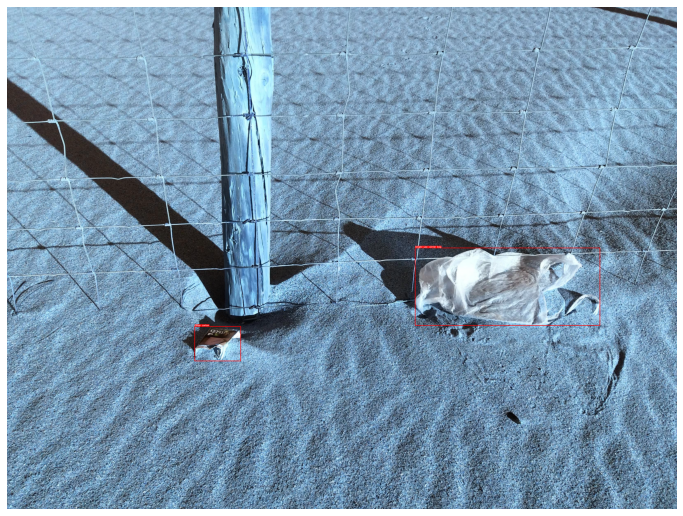

In [39]:
# Let's check an random original image from TACO Dataset (without scaling)

img_obj = get_random_image(dataset)
image               = img_obj[0]
bboxes              = img_obj[1]
category_ids        = img_obj[2]
category_id_to_name = img_obj[3]
height              = img_obj[4]
width               = img_obj[5]
image_path          = img_obj[6]
rand_number         = img_obj[7]

visualize(image, bboxes, category_ids, category_id_to_name)

In [43]:
INPUT_IMAGE_DIR = "/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/validation/images/{:0>6}.jpg".format(rand_number)
INPUT_IMAGE_DIR

'/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/validation/images/000928.jpg'

In [44]:
INPUT_IMAGE_DIR = "/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/train/images/{:0>6}.jpg".format(rand_number)
INPUT_IMAGE_TEST_DIR =  "teste/lixo-manhã.png'

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(TRAINED_MODEL_DIR)
detector.setJsonPath("json/detection_config.json")
detector.loadModel()
detections = detector.detectObjectsFromImage(input_image = INPUT_IMAGE_DIR, output_image_path="detected.jpg")
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

Plastic bag & wrapper  :  55.26031851768494  :  [190, 114, 281, 156]
Bottle  :  83.66183042526245  :  [91, 154, 114, 169]
Can  :  80.20788431167603  :  [91, 154, 114, 169]
Carton  :  52.391648292541504  :  [91, 154, 114, 169]
Cup  :  58.50716829299927  :  [91, 154, 114, 169]
Plastic bag & wrapper  :  89.25897479057312  :  [91, 154, 114, 169]


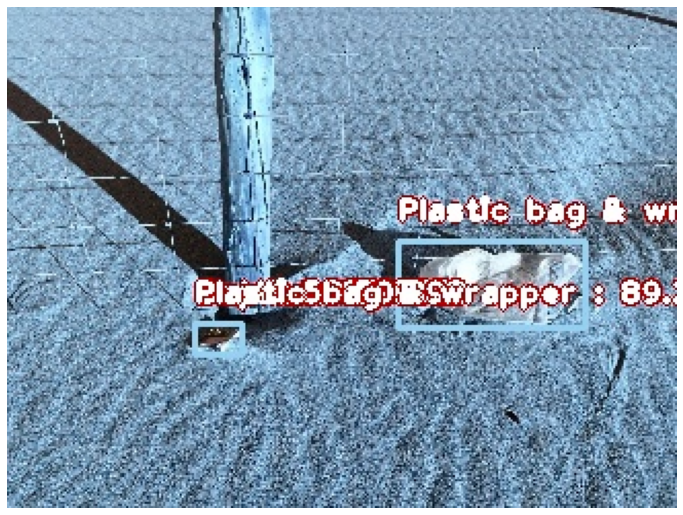

In [45]:
img = cv2.imread("detected.jpg")
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(img)

In [46]:
INPUT_IMAGE_DIR = 'teste/lixo-manhã.png'

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(TRAINED_MODEL_DIR)
detector.setJsonPath("json/detection_config.json")
detector.loadModel()
detections = detector.detectObjectsFromImage(input_image = INPUT_IMAGE_DIR, output_image_path="detected.jpg")
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

Can  :  65.31018614768982  :  [196, 293, 305, 390]
Carton  :  53.84410619735718  :  [193, 292, 311, 386]
Plastic bag & wrapper  :  80.53914904594421  :  [193, 292, 311, 386]
Bottle cap  :  71.49326801300049  :  [374, 153, 381, 156]
Cigarette  :  56.13895058631897  :  [374, 153, 381, 156]
Unlabeled litter  :  64.80174660682678  :  [374, 153, 381, 156]
Bottle  :  83.57217311859131  :  [374, 146, 409, 160]
Can  :  84.86053347587585  :  [374, 146, 409, 160]
Carton  :  66.20899438858032  :  [374, 146, 409, 160]
Cup  :  61.79500222206116  :  [374, 146, 409, 160]
Paper  :  63.624221086502075  :  [374, 146, 409, 160]
Plastic bag & wrapper  :  82.04481601715088  :  [374, 146, 409, 160]
Unlabeled litter  :  75.41987299919128  :  [386, 146, 410, 160]
Unlabeled litter  :  50.00580549240112  :  [476, 150, 485, 154]
Bottle  :  55.40134310722351  :  [470, 147, 493, 161]
Can  :  57.82466530799866  :  [470, 147, 493, 161]
Plastic bag & wrapper  :  60.84672212600708  :  [470, 147, 493, 161]
Unlabeled li

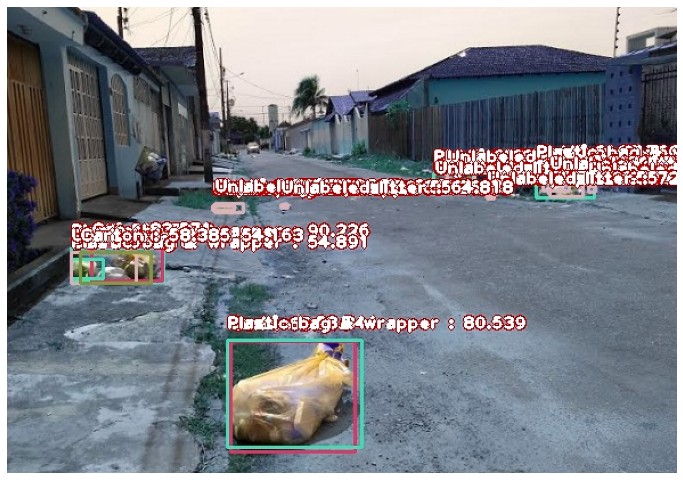

In [47]:
img = cv2.imread("detected.jpg")
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(img)

In [5]:
INPUT_IMAGE_DIR = 'teste/download.jpeg'

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(TRAINED_MODEL_DIR)
detector.setJsonPath("json/detection_config.json")
detector.loadModel()
detections = detector.detectObjectsFromImage(input_image = INPUT_IMAGE_DIR, output_image_path="detected.jpg")
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

/home/trs/ML_Projects/Huawei_Curupira/curupira_env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Plastic bag & wrapper  :  63.04239630699158  :  [56, 3, 126, 30]
Carton  :  57.492077350616455  :  [109, 74, 149, 117]
Plastic bag & wrapper  :  72.86931276321411  :  [109, 74, 149, 117]
Bottle  :  69.57092881202698  :  [214, 52, 220, 56]
Bottle cap  :  74.49818253517151  :  [214, 52, 220, 56]
Carton  :  57.609641551971436  :  [214, 52, 220, 56]
Cigarette  :  56.85986280441284  :  [214, 52, 220, 56]
Other plastic  :  72.45755791664124  :  [214, 52, 220, 56]
Unlabeled litter  :  82.04613327980042  :  [214, 52, 220, 56]
Aluminium foil  :  52.16062664985657  :  [214, 52, 221, 57]
Can  :  64.23678398132324  :  [214, 52, 221, 57]
Plastic bag & wrapper  :  72.99234867095947  :  [214, 52, 221, 57]
Plastic bag & wrapper  :  53.72400879859924  :  [228, 64, 264, 70]
Plastic bag & wrapper  :  67.81569123268127  :  [0, 80, 12, 85]
Unlabeled litter  :  66.88214540481567  :  [0, 80, 12, 85]
Carton  :  50.59272050857544  :  [36, 98, 62, 108]
Paper  :  52.91717052459717  :  [36, 98, 62, 108]
Plastic b

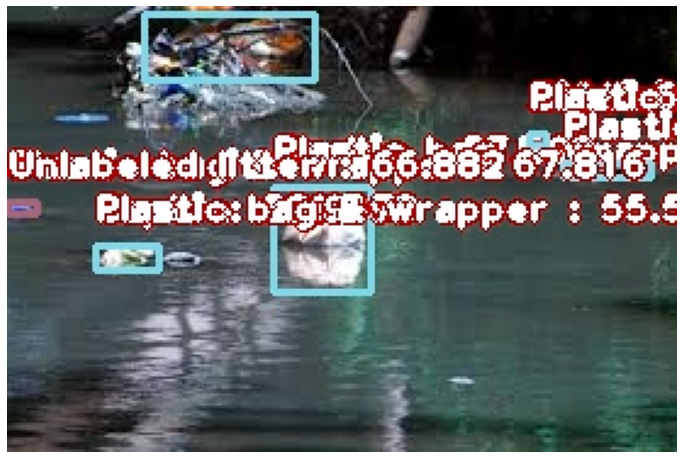

In [51]:
img = cv2.imread("detected.jpg")
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(img)

### Nexts inspections: consider only the first three biggests percentages

# Final Considerations

1. In order to improve the model's perfomance , it is highly recommended to expand the dataset through Data Augmentation. For example, we could add Gaussian blur and AWG noise, change image exposure and contrast, rotate and crop images.


2. The validation should be done more carefully, maybe through cross validation methods and etc.